# Chapter 6 Clustering Part 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from patsy import dmatrix
import plotly.graph_objects as go

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)

<ipython-input-2-4a1a24ff24ef>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_data.dropna(inplace=True)


# How Spline Smoothing works

Smoothing a Country of choice

In [ ]:
# The plotting function
def plot_all_sectors_spline_subplots_no_legend(df, country_name, df_spline=20, degree=3, alpha=1.0):
    df_country = df[df["country"] == country_name].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
               'International Aviation', 'Power', 'Residential']
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    fig = make_subplots(rows=3, cols=2, subplot_titles=sectors)

    for i, sector in enumerate(sectors):
        t = df_country['t'].values
        y = df_country[sector].values
        date = df_country['date']

        basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                        {"t": t}, return_type='dataframe')
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        row = i // 2 + 1
        col = i % 2 + 1

        fig.add_trace(go.Scatter(x=date, y=y, mode='lines',
                                 line=dict(dash='dot', width=1),
                                 showlegend=False),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=date, y=y_smooth, mode='lines',
                                 line=dict(color=colors[i], width=2),
                                 showlegend=False),
                      row=row, col=col)

    fig.update_layout(
        height=900,
        width=1000,
        title_text=f"P-spline Smoothing for All Sectors - {country_name}",
        template="plotly_white",
        showlegend=False
    )

    return fig

# Generate the subplot visualization for a specific country
fig_germany = plot_all_sectors_spline_subplots_no_legend(EU_data, "Germany")
fig_germany.show()

All spline smooth plots in one

In [ ]:
def plot_all_sectors_spline_plotly(
    df: pd.DataFrame,
    country_name: str,
    df_spline: int = 20,
    degree: int = 3,
    alpha: float = 1.0,
    raw_opacity: float = 0.4,
    show_legend: bool = True
):
    # Filter & prepare
    df_country = df[df["country"] == country_name].copy()
    df_country = df_country.sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Sectors & colors
    sectors = [
        'Domestic Aviation', 'Ground Transport', 'Industry',
        'International Aviation', 'Power', 'Residential'
    ]
    colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']

    # Build figure
    fig = go.Figure()
    for i, sector in enumerate(sectors):
        t = df_country['t'].values
        y = df_country[sector].values
        dates = df_country['date']

        # Spline basis + Ridge fit
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
            {"t": t}, return_type='dataframe'
        )
        ridge = Ridge(alpha=alpha, fit_intercept=False)
        ridge.fit(basis, y)
        y_smooth = ridge.predict(basis)

        # Raw trace
        fig.add_trace(go.Scatter(
            x=dates, y=y,
            mode='lines',
            name=f'{sector} (raw)',
            opacity=raw_opacity,
            line=dict(dash='dot'),
            showlegend=show_legend
        ))
        # Smoothed trace
        fig.add_trace(go.Scatter(
            x=dates, y=y_smooth,
            mode='lines',
            name=f'{sector} (smoothed)',
            line=dict(color=colors[i], width=2),
            showlegend=show_legend
        ))

    # Layout
    fig.update_layout(
        title=f"P-spline Smoothing for All Sectors — {country_name}",
        xaxis_title="Date",
        yaxis_title="Emissions (MtCO₂)",
        template="plotly_white"
    )
    fig.show()




In [ ]:
# Full legend:
plot_all_sectors_spline_plotly(EU_data, "Italy")
#plot_all_sectors_spline_plotly(EU_data, "Italy", show_legend=False)

# Parameter sensitivity Test

Testing if other configurations of hyperparam work better

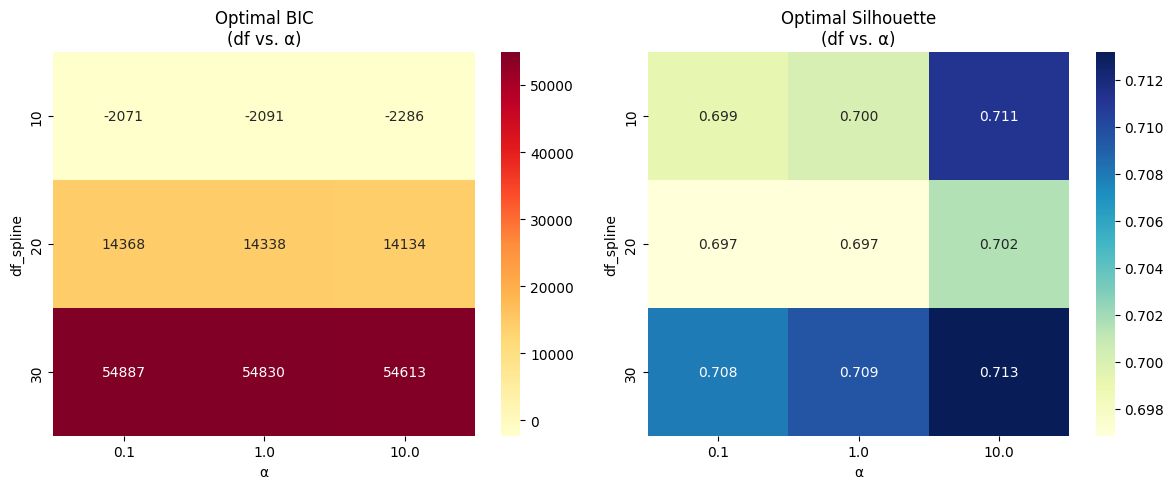

In [ ]:
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

df_spline_list = [10, 20, 30]
alpha_list     = [0.1, 1.0, 10.0]
degree_fixed   = 3
countries = EU_data['country'].unique()

grid_results = []

for df_spline in df_spline_list:
    for alpha in alpha_list:
        # 1) Extract full‐coef features under this smoothing config
        all_coefs = []
        for country in countries:
            df_ct = (EU_data[EU_data['country']==country]
                     .sort_values('date')
                     .reset_index(drop=True))
            df_ct['t'] = np.arange(len(df_ct))

            country_coefs = []
            for sec in sectors:
                basis = dmatrix(
                    f"bs(t, df={df_spline}, degree={degree_fixed}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe'
                )
                y = df_ct[sec].values
                ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
                country_coefs.extend(ridge.coef_)
            all_coefs.append(country_coefs)

        X = np.array(all_coefs)  # shape [n_countries, df_spline*6]
        X_scaled = StandardScaler().fit_transform(X)

        # 2) Compute BIC & Silhouette over K=2…10
        bic_scores = []
        sil_scores = []
        for k in range(2, 11):
            gmm = GaussianMixture(n_components=k,
                                  covariance_type='full',
                                  random_state=42)
            gmm.fit(X_scaled)
            labels = gmm.predict(X_scaled)
            bic_scores.append(gmm.bic(X_scaled))
            sil_scores.append(silhouette_score(X_scaled, labels))

        # 3) Record the *best* metrics
        grid_results.append({
            'df_spline':       df_spline,
            'alpha':           alpha,
            'best_BIC':        min(bic_scores),
            'best_Silhouette': max(sil_scores)
        })

grid_df = pd.DataFrame(grid_results)

# 4) Pivot into heatmap‐friendly form
pivot_bic = grid_df.pivot(index='df_spline',
                          columns='alpha',
                          values='best_BIC')
pivot_sil= grid_df.pivot(index='df_spline',
                         columns='alpha',
                         values='best_Silhouette')

# 5) Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(pivot_bic, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Optimal BIC\n(df vs. α)")
plt.xlabel("α")
plt.ylabel("df_spline")

plt.subplot(1,2,2)
sns.heatmap(pivot_sil, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Optimal Silhouette\n(df vs. α)")
plt.xlabel("α")
plt.ylabel("df_spline")

plt.tight_layout()
plt.show()


# Spline Validation on overlapping periods

Calculating the RMSE between the ovelapping periods and trimmed spline curves

In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0

# --- Function to compute spline RMSE between two overlapping periods ---
def compute_spline_rmse(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define two fitting periods
    p1_start, p1_end = '2019-01-01', '2023-01-01'
    p2_start, p2_end = '2020-01-01', '2024-01-01'

    df1 = df_country[(df_country['date'] >= p1_start) & (df_country['date'] < p1_end)]
    df2 = df_country[(df_country['date'] >= p2_start) & (df_country['date'] < p2_end)]
    if df1.empty or df2.empty:
        return None

    # Fit splines
    X1 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df1['t']}, return_type='dataframe')
    m1 = Ridge(alpha=alpha, fit_intercept=False).fit(X1, df1[sector])
    y1 = m1.predict(X1)

    X2 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df2['t']}, return_type='dataframe')
    m2 = Ridge(alpha=alpha, fit_intercept=False).fit(X2, df2[sector])
    y2 = m2.predict(X2)

    # Compute RMSE on overlapping dates
    overlap_dates = df1['date'].isin(df2['date'])
    idx1 = df1[overlap_dates].index
    idx2 = df2[df2['date'].isin(df1['date'])].index
    if len(idx1) == 0:
        return None

    rmse = np.sqrt(mean_squared_error(y1[idx1], y2[idx2]))
    return {'country': country, 'sector': sector, 'rmse_overlap': rmse}

# --- Batch processing to build RMSE table ---
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
countries = EU_data['country'].unique()

results = []
for country in countries:
    for sector in sectors:
        res = compute_spline_rmse(country, sector)
        if res:
            results.append(res)

results_df = pd.DataFrame(results)
print("RMSE overlap summary (first 10 rows):")
print(results_df.head(10))

# --- Function to plot trimmed overlap of smoothed splines ---
def plot_trimmed_overlap(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define periods
    fit1_start, fit1_end = '2019-01-01', '2023-01-01'
    fit2_start, fit2_end = '2020-01-01', '2024-01-01'
    overlap_start, overlap_end = '2020-01-01', '2023-01-01'

    df1 = df_country[(df_country['date'] >= fit1_start) & (df_country['date'] < fit1_end)].copy()
    df2 = df_country[(df_country['date'] >= fit2_start) & (df_country['date'] < fit2_end)].copy()

    # Fit splines
    for df_period in (df1, df2):
        X = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                    {"t": df_period['t']}, return_type='dataframe')
        model = Ridge(alpha=alpha, fit_intercept=False).fit(X, df_period[sector])
        df_period['y_smooth'] = model.predict(X)

    # Filter overlap
    df1_o = df1[(df1['date'] >= overlap_start) & (df1['date'] < overlap_end)]
    df2_o = df2[(df2['date'] >= overlap_start) & (df2['date'] < overlap_end)]

    # Plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df1_o['date'], y=df1_o['y_smooth'],
                             mode='lines', name="Fit 2019–2023", line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df2_o['date'], y=df2_o['y_smooth'],
                             mode='lines', name="Fit 2020–2024",
                             line=dict(color='orange', dash='dash')))
    fig.update_layout(
        title=f"Spline Overlap: {country} — {sector}",
        xaxis_title="Date",
        yaxis_title="Emissions (smoothed)",
        template="plotly_white",
        annotations=[dict(
            text="Overlap region (2020–2023) highlights fit consistency",
            xref='paper', yref='paper', x=0, y=-0.15, showarrow=False
        )]
    )
    fig.show()

# Example visualization
plot_trimmed_overlap("Germany", "Power")


RMSE overlap summary (first 10 rows):
   country                  sector  rmse_overlap
0  Austria       Domestic Aviation      0.000048
1  Austria        Ground Transport      0.002607
2  Austria                Industry      0.016806
3  Austria  International Aviation      0.002282
4  Austria                   Power      0.011202
5  Austria             Residential      0.002534
6  Belgium       Domestic Aviation      0.000013
7  Belgium        Ground Transport      0.004995
8  Belgium                Industry      0.008765
9  Belgium  International Aviation      0.002497


In [ ]:
countries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [ ]:
# --- Function to compute spline RMSE between two overlapping periods ---
def compute_spline_rmse(country, sector):
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))

    # Define periods
    p1_start, p1_end = '2019-01-01', '2023-01-01'
    p2_start, p2_end = '2020-01-01', '2024-01-01'

    df1 = df_country[(df_country['date'] >= p1_start) & (df_country['date'] < p1_end)]
    df2 = df_country[(df_country['date'] >= p2_start) & (df_country['date'] < p2_end)]
    if df1.empty or df2.empty:
        return None

    # Fit splines for both periods
    X1 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df1['t']}, return_type='dataframe')
    m1 = Ridge(alpha=alpha, fit_intercept=False).fit(X1, df1[sector])
    y1 = m1.predict(X1)

    X2 = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
                 {"t": df2['t']}, return_type='dataframe')
    m2 = Ridge(alpha=alpha, fit_intercept=False).fit(X2, df2[sector])
    y2 = m2.predict(X2)

    # Compute RMSE on overlapping dates
    overlap_mask = df1['date'].isin(df2['date'])
    if not overlap_mask.any():
        return None

    idx1 = df1[overlap_mask].index
    idx2 = df2[df2['date'].isin(df1['date'])].index
    rmse = np.sqrt(mean_squared_error(y1[idx1], y2[idx2]))
    return {'country': country, 'sector': sector, 'rmse_overlap': rmse}

# --- Batch processing to build RMSE DataFrame ---
results = []
for country in countries:
    for sector in sectors:
        res = compute_spline_rmse(country, sector)
        if res:
            results.append(res)

results_df = pd.DataFrame(results)

# --- Compute average RMSE across sectors and overall ---
sector_rmse_summary = results_df.groupby("sector")["rmse_overlap"].mean().rename("avg_rmse")
overall_avg_rmse = sector_rmse_summary.mean()

# Display results
print("Average RMSE across sectors:")
print(sector_rmse_summary.to_frame())
print(f"\nOverall average RMSE: {overall_avg_rmse:.4f}")


Average RMSE across sectors:
                        avg_rmse
sector                          
Domestic Aviation       0.000494
Ground Transport        0.006158
Industry                0.005479
International Aviation  0.004173
Power                   0.016654
Residential             0.005849

Overall average RMSE: 0.0065


# Feature Extraction - Spline coefficients

Exctracting the spline features for clustering. Here we are not considering the mean of the curve but spline coeff of 20.

In [ ]:
df_spline = 20
degree = 3
alpha = 1.0

# --- Feature Extraction: spline coefficients ---
features = []
for country in countries:
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))
    coefs = []
    for sector in sectors:
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
            {"t": df_country['t']},
            return_type='dataframe'
        )
        ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, df_country[sector])
        coefs.extend(ridge.coef_)
    features.append(coefs)

X = np.array(features)
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
print(features)

[[np.float64(8.458477276031623e-05), np.float64(0.00013116205342952812), np.float64(0.0001267743534186316), np.float64(0.0001943162830582249), np.float64(0.00011686054511988469), np.float64(8.066981651767954e-05), np.float64(0.00019261604486454017), np.float64(-5.0382341637953765e-06), np.float64(0.0002614145719387909), np.float64(0.0001477862700699731), np.float64(3.4137828154853236e-05), np.float64(0.00013387799860104112), np.float64(6.716656884592734e-05), np.float64(7.402493465597845e-05), np.float64(0.00014528049496824268), np.float64(6.790242837722359e-05), np.float64(0.00012231942160917622), np.float64(0.00022017021229294267), np.float64(0.00018596698297817577), np.float64(0.00014654517075768516), np.float64(0.054432093210062704), np.float64(0.07117383881810971), np.float64(0.06138924001711668), np.float64(0.06992997191083773), np.float64(0.0645494110812887), np.float64(0.05820667151216998), np.float64(0.07728341742266576), np.float64(0.054010570877064026), np.float64(0.07290994

In [ ]:
print(X_scaled)

[[-0.52912358 -0.56716617 -0.51674914 ...  0.04594022 -0.31479797
  -0.3308042 ]
 [-0.5544228  -0.60618551 -0.54816312 ...  0.26898578  0.07686078
   0.04074925]
 [-0.54456569 -0.60881522 -0.53376491 ...  0.3101788  -0.56708601
  -0.58443893]
 ...
 [-0.06026318  0.43915218 -0.06462891 ...  0.25970849 -0.56419542
  -0.59088189]
 [-0.51148276 -0.53963777 -0.47499524 ...  0.01365878 -0.19715499
  -0.16684578]
 [ 0.64319497  0.81104385  0.88461299 ...  1.31903107  1.7486385
   1.29685096]]


# Model selection via BIC and Silhouette

In [ ]:
# --- Model selection via BIC and Silhouette ---
results = []
Ks = range(2, 11)  # test cluster counts from 2 to 10
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    labels = gmm.predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    results.append({'n_clusters': k, 'BIC': bic, 'Silhouette': sil_score})

results_df = pd.DataFrame(results)
print("Model selection metrics:")
print(results_df)



Model selection metrics:
   n_clusters            BIC  Silhouette
0           2   14338.213133    0.696875
1           3   37301.410025    0.390708
2           4   62237.993043    0.355442
3           5   87141.077767    0.377785
4           6  112211.568405    0.355815
5           7  137243.512244    0.376163
6           8  162313.493586    0.376671
7           9  186548.562853    0.340528
8          10  211973.914239    0.298165


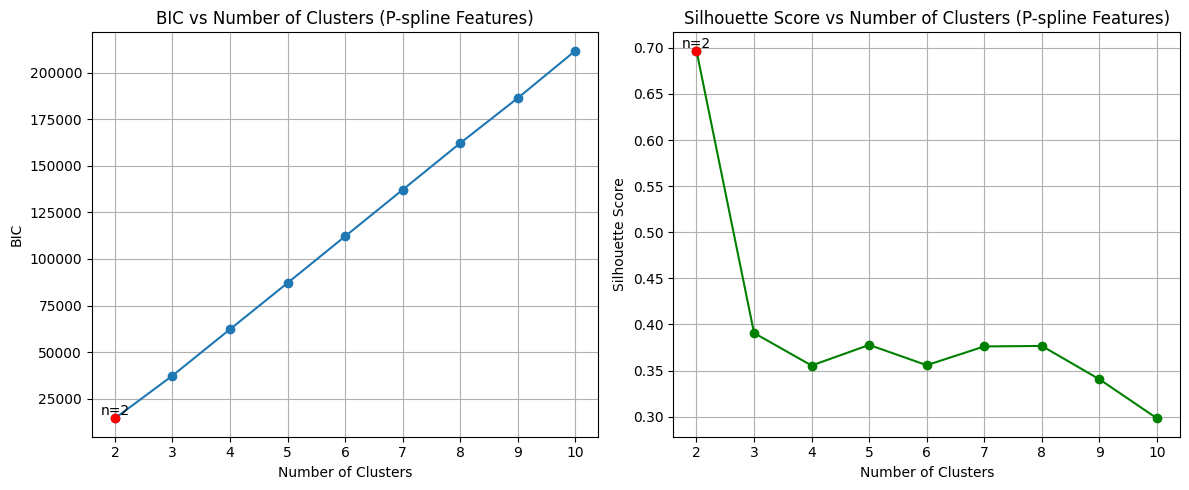

Best BIC at n=2: 14338.21
Best Silhouette Score at n=2: 0.6969


In [ ]:
bic_scores, silhouette_scores = [], []
n_components_range = range(2, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    bic_scores.append(gmm.bic(X_scaled))
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Identifying optimal values
optimal_bic_n = n_components_range[np.argmin(bic_scores)]
optimal_sil_n = n_components_range[np.argmax(silhouette_scores)]

# Plot results
plt.figure(figsize=(12, 5))

# BIC Plot
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.scatter(optimal_bic_n, min(bic_scores), color='red', zorder=5)
plt.text(optimal_bic_n, min(bic_scores), f"n={optimal_bic_n}", va='bottom', ha='center')
plt.title('BIC vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.grid(True)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(n_components_range, silhouette_scores, marker='o', color='green', label='Silhouette')
plt.scatter(optimal_sil_n, max(silhouette_scores), color='red', zorder=5)
plt.text(optimal_sil_n, max(silhouette_scores), f"n={optimal_sil_n}", va='bottom', ha='center')
plt.title('Silhouette Score vs Number of Clusters (P-spline Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Best BIC at n={optimal_bic_n}: {min(bic_scores):.2f}")
print(f"Best Silhouette Score at n={optimal_sil_n}: {max(silhouette_scores):.4f}")


# GMM Model with Optimal Clusters

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

optimal_k = 2

In [ ]:
# --- 3) Fit final GMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)
responsibilities = gmm.predict_proba(X_scaled)
active_clusters = np.unique(labels)

In [ ]:
print(active_clusters)

[0 1]


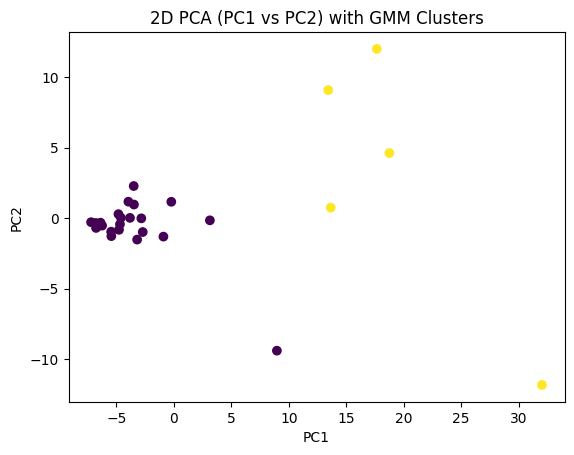

In [ ]:
# --- 4) PCA for visualization ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4a) 2D PCA plot (PC1 vs PC2)
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.title('2D PCA (PC1 vs PC2) with GMM Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

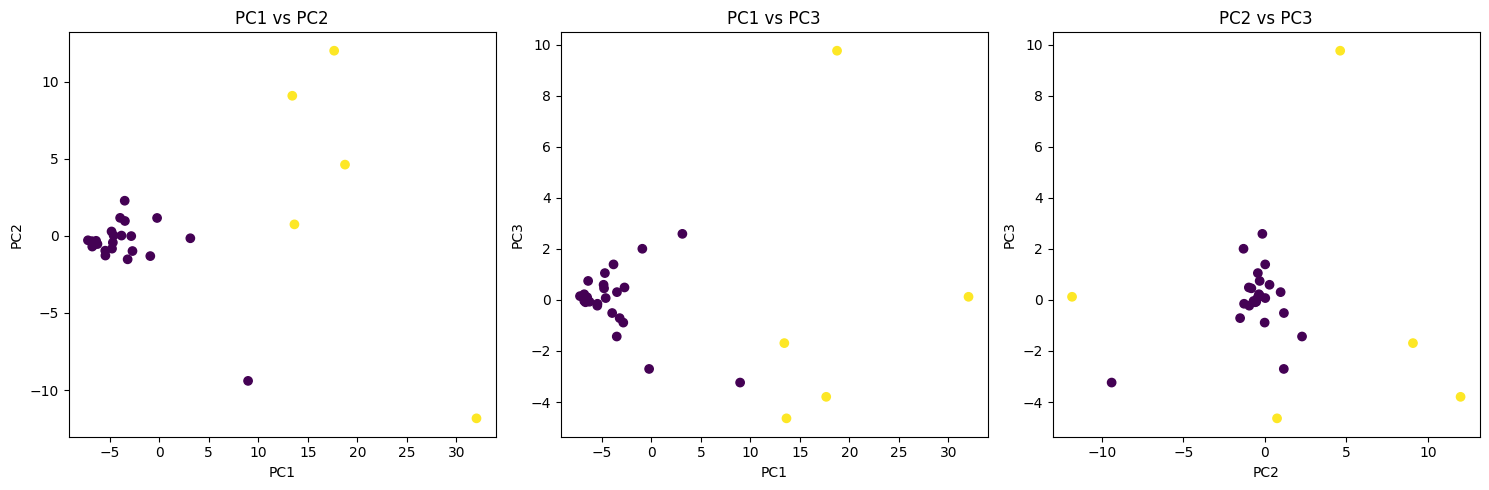

In [ ]:
# 4b) Trellis of pairwise PCA components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
pairs = [(0,1), (0,2), (1,2)]
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(X_pca[:,i], X_pca[:,j], c=labels)
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')
    ax.set_title(f'PC{i+1} vs PC{j+1}')
plt.tight_layout()
plt.show()

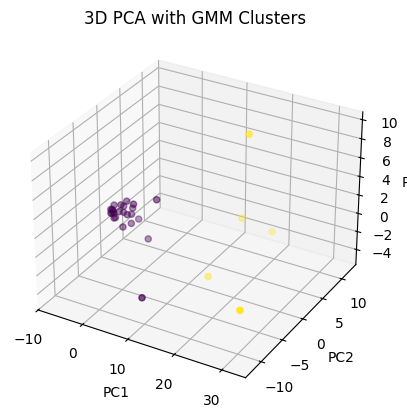

In [ ]:
# 4c) 3D PCA plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA with GMM Clusters')
plt.show()

In [ ]:
# --- 5) Cluster assignments and posterior probs ---
cluster_df = pd.DataFrame({
    'country': countries,
    'cluster': labels,
    'posterior_prob': responsibilities.max(axis=1)
})
cluster_df_sorted = cluster_df.sort_values(by='cluster').reset_index(drop=True)

# Display cluster table and active clusters
print("Active clusters:", active_clusters)
print(cluster_df_sorted)

Active clusters: [0 1]
           country  cluster  posterior_prob
0          Austria        0             1.0
1          Belgium        0             1.0
2         Bulgaria        0             1.0
3          Croatia        0             1.0
4           Cyprus        0             1.0
5   Czech Republic        0             1.0
6          Denmark        0             1.0
7          Estonia        0             1.0
8          Finland        0             1.0
9           Greece        0             1.0
10         Ireland        0             1.0
11         Hungary        0             1.0
12          Latvia        0             1.0
13           Malta        0             1.0
14      Luxembourg        0             1.0
15       Lithuania        0             1.0
16        Slovakia        0             1.0
17        Slovenia        0             1.0
18          Sweden        0             1.0
19     Netherlands        0             1.0
20          Norway        0             1.0
21       

# BGMM with Dirichlet Process

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# --- 1) Extract spline coefficients and full smoothed series ---
features = []
smoothed = {}  # country -> sector -> (dates, y_smooth)
for country in countries:
    df_ct = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    coefs = []
    smoothed[country] = {}
    # build basis once
    basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe')
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        # coefficients
        coefs.extend(model.coef_)
        # full smoothed series
        smoothed[country][sector] = model.predict(basis)
    features.append(coefs)

X = np.array(features)

# --- 2) Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X_scaled)

[[-5.34799422e-01 -5.47654539e-01 -5.51764768e-01 ... -3.54057974e-01
  -3.22812686e-01 -3.31036992e-01]
 [-5.60673898e-01 -5.81927958e-01 -5.86214448e-01 ...  1.57232703e-01
   6.46953073e-02  4.25489303e-02]
 [-5.54331124e-01 -5.74849534e-01 -5.83872181e-01 ... -5.82596988e-01
  -5.76780339e-01 -5.84444866e-01]
 ...
 [ 6.33686891e-04  1.72829681e-01  2.51844518e-01 ... -5.84057188e-01
  -5.80835675e-01 -5.88865691e-01]
 [-5.17190179e-01 -5.22459814e-01 -5.16971261e-01 ... -2.03687248e-01
  -1.93747389e-01 -1.64400054e-01]
 [ 6.88042195e-01  6.96013356e-01  9.09421355e-01 ...  2.41253265e+00
   1.56851284e+00  1.33081401e+00]]


In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
n_components = 10  # truncation for DP
weight_concentration_prior = 0.5

# --- 3) Fit DP-BGMM ---
dpbgmm = BayesianGaussianMixture(
    n_components=n_components,
    weight_concentration_prior=weight_concentration_prior,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
labels = dpbgmm.predict(X_scaled)
responsibilities = dpbgmm.predict_proba(X_scaled)
active_clusters = np.unique(labels)
print(active_clusters)

[0 1 2 3 4 5 6 7 8 9]


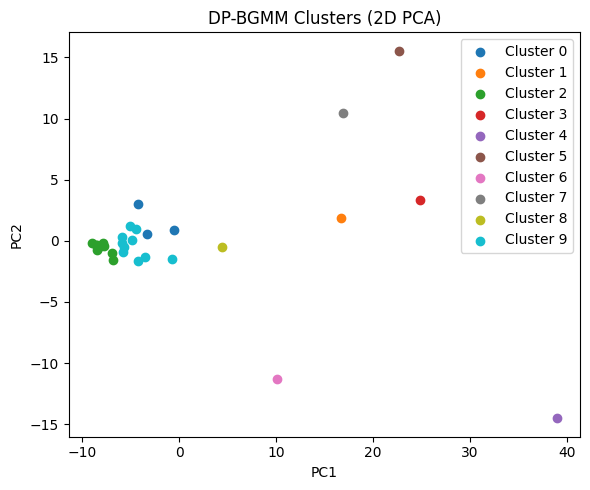

In [ ]:
# --- 4) PCA for visualization ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 4a) 2D PCA
plt.figure(figsize=(6,5))
for cl in active_clusters:
    idx = labels==cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {cl}')
plt.title('DP-BGMM Clusters (2D PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

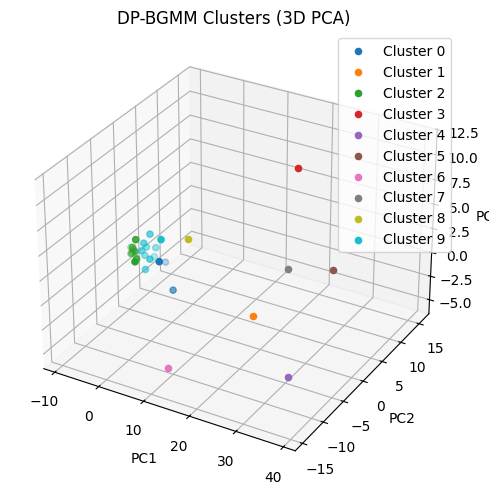

In [ ]:
# 4b) 3D PCA
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
for cl in active_clusters:
    idx = labels==cl
    ax.scatter(X_pca[idx,0], X_pca[idx,1], X_pca[idx,2], label=f'Cluster {cl}')
ax.set_title('DP-BGMM Clusters (3D PCA)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()

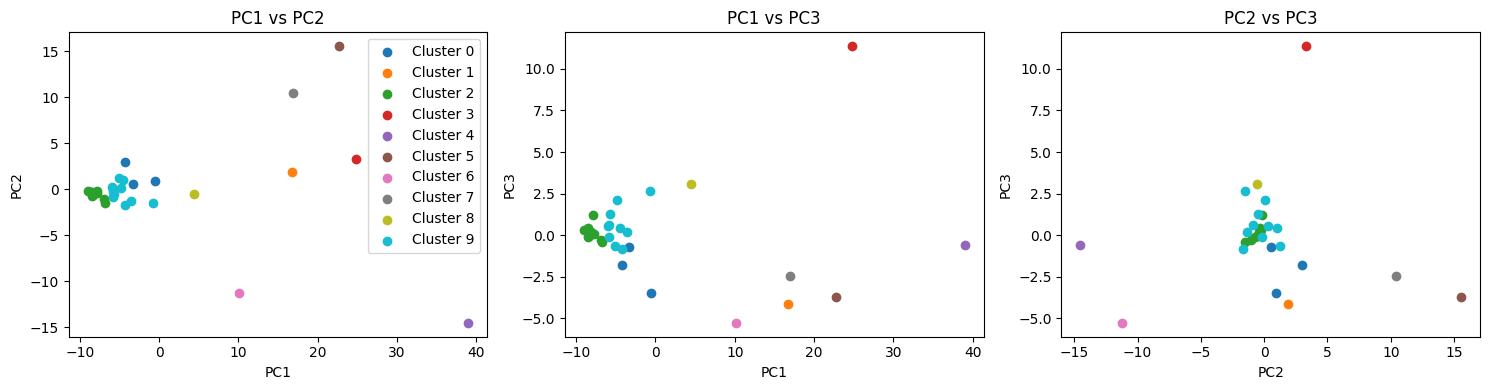

In [ ]:
# 4c) Trellis: PC1 vs PC2, PC1 vs PC3, PC2 vs PC3
fig, axes = plt.subplots(1,3,figsize=(15,4))
pairs = [(0,1),(0,2),(1,2)]
for ax, (i,j) in zip(axes, pairs):
    for cl in active_clusters:
        idx = labels==cl
        ax.scatter(X_pca[idx,i], X_pca[idx,j], label=f'Cluster {cl}')
    ax.set_xlabel(f'PC{i+1}'); ax.set_ylabel(f'PC{j+1}')
    ax.set_title(f'PC{i+1} vs PC{j+1}')
axes[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
# --- 5) Country assignments & posterior probs ---
cluster_df = pd.DataFrame({
    'country': countries,
    'cluster': labels,
    'posterior_prob': responsibilities.max(axis=1)
})
print("Active clusters:", active_clusters)
print(cluster_df.sort_values('cluster').to_string(index=False))

Active clusters: [0 1 2 3 4 5 6 7 8 9]
       country  cluster  posterior_prob
Czech Republic        0             1.0
        Greece        0             1.0
        Norway        0             1.0
         Italy        1             1.0
       Estonia        2             1.0
        Latvia        2             1.0
        Cyprus        2             1.0
       Croatia        2             1.0
    Luxembourg        2             1.0
         Malta        2             1.0
      Slovakia        2             1.0
      Slovenia        2             1.0
     Lithuania        2             1.0
      Bulgaria        2             1.0
United Kingdom        3             1.0
       Germany        4             1.0
        France        5             1.0
        Poland        6             1.0
         Spain        7             1.0
   Netherlands        8             1.0
       Austria        9             1.0
       Belgium        9             1.0
       Finland        9             1.0
 

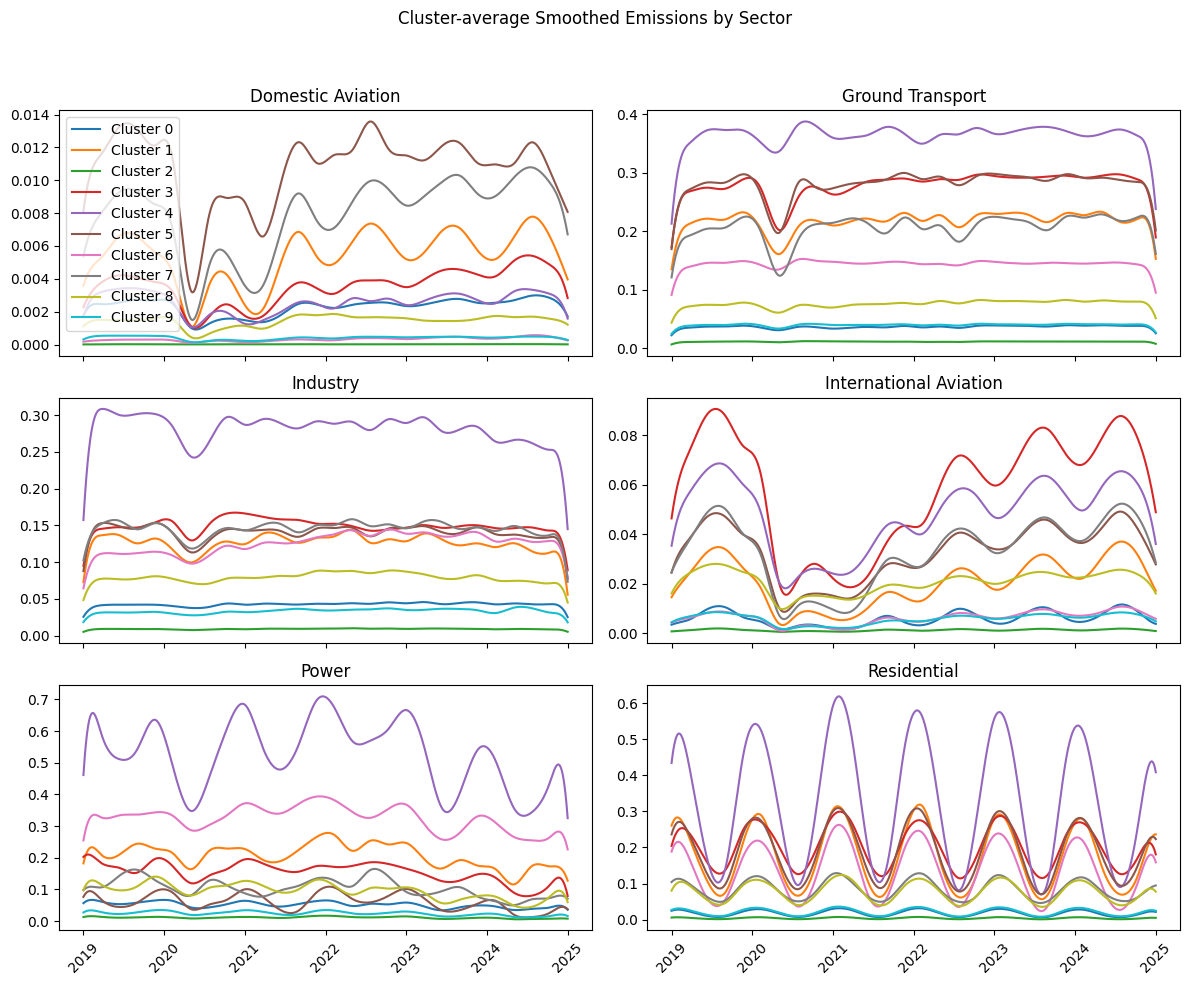

In [ ]:
# --- 6) Sector-level cluster differences ---
# average smoothed emission per cluster & sector
dates = EU_data[EU_data['country']==countries[0]]['date']
fig, axes = plt.subplots(3,2, figsize=(12,10), sharex=True)
axes = axes.flatten()
for i, sector in enumerate(sectors):
    ax = axes[i]
    for cl in active_clusters:
        # collect smoothed arrays for countries in this cluster
        arrs = [smoothed[c][sector] for c, lab in zip(countries, labels) if lab==cl]
        if arrs:
            mean_series = np.mean(arrs, axis=0)
            ax.plot(dates, mean_series, label=f'Cluster {cl}')
    ax.set_title(sector)
    ax.tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left')
plt.suptitle('Cluster-average Smoothed Emissions by Sector')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# Comparison GMM vs BGMM

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

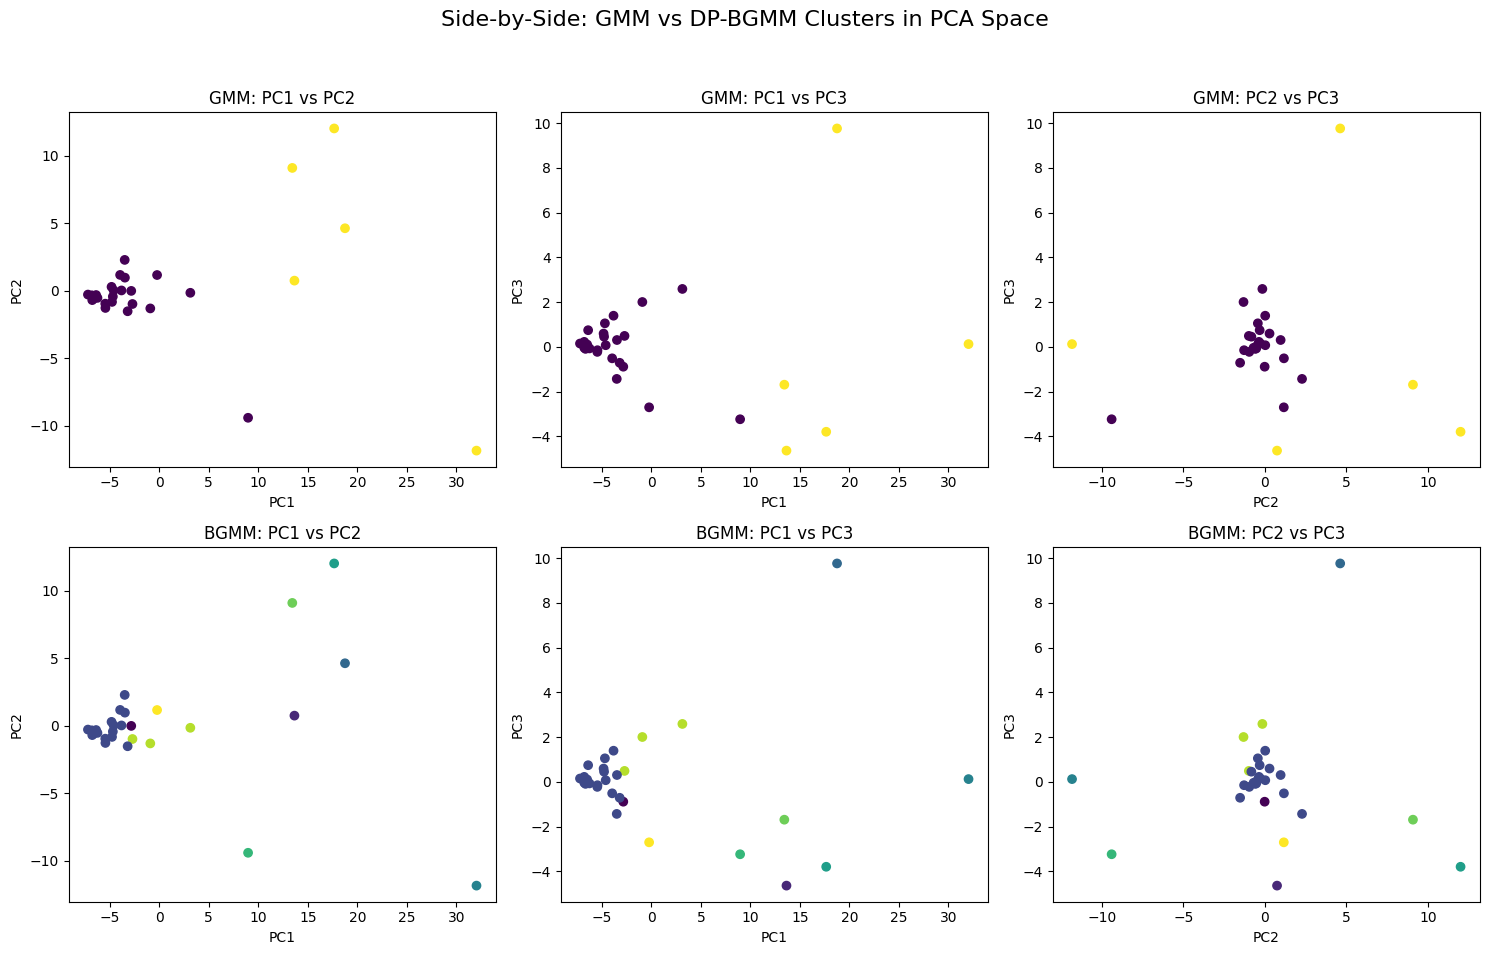

In [ ]:
# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
optimal_k = 2
dp_components = 10
dp_alpha = 0.5

# --- Feature extraction ---
features = []
for country in countries:
    df_ct = EU_data[EU_data['country'] == country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    basis = dmatrix(
        f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
        {"t": df_ct['t']},
        return_type='dataframe'
    )
    coefs = []
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        coefs.extend(model.coef_)
    features.append(coefs)

X = np.array(features)

# --- Standardize & PCA ---
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Fit GMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

# --- Fit DP-BGMM ---
dpbgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
bgmm_labels = dpbgmm.predict(X_scaled)

# --- Plot comparison ---
pairs = [(0,1), (0,2), (1,2)]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col, (i, j) in enumerate(pairs):
    # GMM row
    ax = axes[0, col]
    ax.scatter(X_pca[:, i], X_pca[:, j], c=gmm_labels, cmap=None)
    ax.set_title(f'GMM: PC{i+1} vs PC{j+1}')
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')
    # BGMM row
    ax = axes[1, col]
    ax.scatter(X_pca[:, i], X_pca[:, j], c=bgmm_labels, cmap=None)
    ax.set_title(f'BGMM: PC{i+1} vs PC{j+1}')
    ax.set_xlabel(f'PC{i+1}')
    ax.set_ylabel(f'PC{j+1}')

fig.suptitle('Side-by-Side: GMM vs DP-BGMM Clusters in PCA Space', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
import plotly.express as px


# --- Fit GMM and DP-BGMM ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42).fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

bgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
bgmm_labels = bgmm.predict(X_scaled)

# --- PCA projection ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- Prepare DataFrames ---
pca_df_gmm = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': gmm_labels.astype(str)
})

pca_df_bgmm = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': bgmm_labels.astype(str)
})

# --- GMM Trellis via Plotly scatter_matrix ---
fig_gmm_matrix = px.scatter_matrix(
    pca_df_gmm,
    dimensions=['PCA1','PCA2','PCA3'],
    color='Cluster',
    title='Trellis View of GMM Clusters in PCA Space'
)
fig_gmm_matrix.update_layout(width=700, height=700)
fig_gmm_matrix.show()

# --- GMM 3D scatter ---
fig_gmm_3d = px.scatter_3d(
    pca_df_gmm, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title="3D PCA Projection with GMM Clusters"
)
fig_gmm_3d.show()

# --- DP-BGMM Trellis via Plotly scatter_matrix ---
fig_bgmm_matrix = px.scatter_matrix(
    pca_df_bgmm,
    dimensions=['PCA1','PCA2','PCA3'],
    color='Cluster',
    title='Trellis View of DP-BGMM Clusters in PCA Space'
)
fig_bgmm_matrix.update_layout(width=700, height=700)
fig_bgmm_matrix.show()

# --- DP-BGMM 3D scatter ---
fig_bgmm_3d = px.scatter_3d(
    pca_df_bgmm, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title="3D PCA Projection with DP-BGMM Clusters"
)
fig_bgmm_3d.show()


In [ ]:

# Build a single DataFrame
cluster_df = pd.DataFrame({
    'Country': countries,
    'GMM_Cluster': gmm_labels,
    'BGMM_Cluster': bgmm_labels
}).set_index('Country')

# Print GMM cluster members
for c in sorted(cluster_df['GMM_Cluster'].unique()):
    members = cluster_df.index[cluster_df['GMM_Cluster'] == c].tolist()
    print(f"\nGMM Cluster {c}:")
    print(members)

# Print DP-BGMM cluster members
for c in sorted(cluster_df['BGMM_Cluster'].unique()):
    members = cluster_df.index[cluster_df['BGMM_Cluster'] == c].tolist()
    print(f"\nDP-BGMM Cluster {c}:")
    print(members)



GMM Cluster 0:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

GMM Cluster 1:
['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']

DP-BGMM Cluster 0:
['Greece']

DP-BGMM Cluster 1:
['Italy']

DP-BGMM Cluster 2:
['Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Norway', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland']

DP-BGMM Cluster 3:
['United Kingdom']

DP-BGMM Cluster 4:
['Germany']

DP-BGMM Cluster 5:
['France']

DP-BGMM Cluster 6:
['Poland']

DP-BGMM Cluster 7:
['Spain']

DP-BGMM Cluster 8:
['Austria', 'Belgium', 'Netherlands']

DP-BGMM Cluster 9:
['Czech Republic']


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import plotly.express as px

# --- 4a) Fit GMM (K=2) ---
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42).fit(X_scaled)
g_labels = gmm.predict(X_scaled)
g_probs  = gmm.predict_proba(X_scaled)

# --- 4b) Fit DP-BGMM (truncation=10) ---
bgmm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior=0.5,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
b_labels = bgmm.predict(X_scaled)
b_probs  = bgmm.predict_proba(X_scaled)

# --- 5) Build feature tables ---
gmm_table = pd.DataFrame({
    'country': countries,
    'country_cluster': g_labels,
    'prob_country_cluster_0': g_probs[:,0],
    'prob_country_cluster_1': g_probs[:,1]
})

bgmm_table = pd.DataFrame({
    'country': countries,
    'country_cluster': b_labels,
})
# add first two posteriors (you can add more if you like)
bgmm_table['prob_country_cluster_0'] = b_probs[:,0]
bgmm_table['prob_country_cluster_1'] = b_probs[:,1]

# --- 6) Choropleth: GMM ---
fig = px.choropleth(
    gmm_table,
    locations="country",
    locationmode="country names",
    color="country_cluster",
    hover_name="country",
    hover_data={
        "prob_country_cluster_0": ':.4f',
        "prob_country_cluster_1": ':.4f',
        "country_cluster": True
    },
    color_continuous_scale=px.colors.diverging.RdYlBu,
    title="Country Clusters by P-Spline + GMM (with posteriors)"
)
fig.update_layout(
    geo=dict(scope="europe", showframe=False, showcoastlines=True),
    margin=dict(r=0, t=50, l=0, b=0)
)
fig.show()

# --- 7) Choropleth: DP-BGMM ---
fig = px.choropleth(
    bgmm_table,
    locations="country",
    locationmode="country names",
    color="country_cluster",
    hover_name="country",
    hover_data={
        "prob_country_cluster_0": ':.4f',
        "prob_country_cluster_1": ':.4f',
        "country_cluster": True
    },
    color_continuous_scale=px.colors.diverging.PiYG,
    title="Country Clusters by P-Spline + DP-BGMM (with posteriors)"
)
fig.update_layout(
    geo=dict(scope="europe", showframe=False, showcoastlines=True),
    margin=dict(r=0, t=50, l=0, b=0)
)
fig.show()


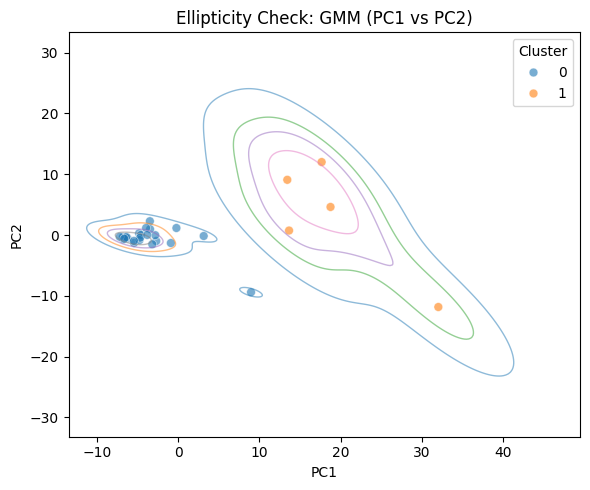

In [ ]:
import seaborn as sns

# --- Ellipticity Check for GMM and DP-BGMM ---
# Reuse X_pca (n_countries × 3) and your labels arrays

# We'll do it for the first two PCs (PC1 vs PC2).
df_gmm = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': gmm_labels.astype(str)
})
df_bgmm = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': bgmm_labels.astype(str)
})

def plot_ellipticity(df, title):
    plt.figure(figsize=(6,5))
    # scatter
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster',
                    palette='tab10', s=40, alpha=0.6, edgecolor='w')
    # KDE contours per cluster
    for cl in df['Cluster'].unique():
        subset = df[df['Cluster'] == cl]
        sns.kdeplot(
            data=subset, x='PC1', y='PC2',
            levels=5,
            cmap=sns.color_palette('tab10', as_cmap=True),
            thresh=0.1, alpha=0.5, linewidths=1
        )
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

# Plot for GMM
plot_ellipticity(df_gmm, "Ellipticity Check: GMM (PC1 vs PC2)")



1. GMM (K=2) — “Classic” mixture on 120-D spline coefs

Blue cluster (the low-emitter group) sits tightly on the left, its density contours are almost perfect ellipses.

Orange cluster (the high-emitter group) is also roughly elliptical, albeit a bit more stretched along PC1.

Take-away: The Gaussian-mixture assumption is quite reasonable here, and K=2 captures the two big “low vs. high” groups cleanly.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bfbc5e856c>:26: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

<ipython-input-78-d1bf

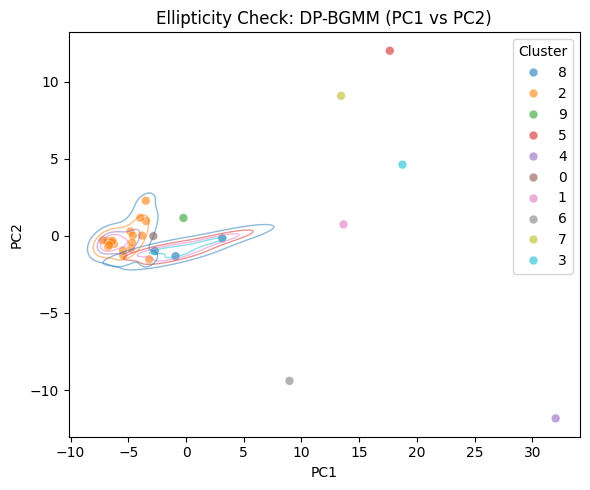

In [ ]:
# Plot for DP-BGMM
plot_ellipticity(df_bgmm, "Ellipticity Check: DP-BGMM (PC1 vs PC2)")

 DP-BGMM (truncation=10) — variational Dirichlet‐process fit

You can see many tiny clusters (labels 8,2,9,5,4,0,1,6,7,3) hugging the same left-hand region. Their contours wildly overlap and are very small (singleton pulls), while a few stragglers sit out in the high-emitter tail.

Take-away: Although the DP prior is “Bayesian,” the variational fit has massively over-fragmented—so many nearly‐zero‐weight components that the Gaussian assumption is never really tested at the group level. The shapes lose their clean ellipses, and interpretability plummets.

# BGMM with varying n

In [ ]:
# --- DP-BGMM fragmentation analysis ---
n_components_list = [3,4,5,6, 7,8, 9, 10, 12, 15]
summary = []

for n in n_components_list:
    dpbgmm = BayesianGaussianMixture(
        n_components=n,
        weight_concentration_prior=weight_concentration_prior,
        weight_concentration_prior_type='dirichlet_process',
        covariance_type='full',
        max_iter=1000,
        random_state=42
    ).fit(X_scaled)
    labels = dpbgmm.predict(X_scaled)
    responsibilities = dpbgmm.predict_proba(X_scaled)
    sizes = pd.Series(labels).value_counts()
    avg_max_prob = responsibilities.max(axis=1).mean()
    summary.append({
        'n_components': n,
        'active_clusters': sizes.size,
        'singleton_clusters': int((sizes == 1).sum()),
        'avg_max_posterior_prob': avg_max_prob
    })

summary_df = pd.DataFrame(summary)

# Display the fragmentation summary
print("DP-BGMM Fragmentation Summary \n", summary_df)


DP-BGMM Fragmentation Summary 
    n_components  active_clusters  singleton_clusters  avg_max_posterior_prob
0             3                3                   0                     1.0
1             4                4                   1                     1.0
2             5                5                   1                     1.0
3             6                6                   3                     1.0
4             7                7                   4                     1.0
5             8                8                   6                     1.0
6             9                9                   6                     1.0
7            10               10                   8                     1.0
8            12               12                  10                     1.0
9            15               15                  13                     1.0


# BGMM with Optimal Clusters

Extracts P-spline coefficients and smoothed sectoral time series.

Standardizes the 120-dimensional feature matrix.

Fits a DP-BGMM with 2 components (optimal K) and computes posterior probabilities.

Projects onto 3 PCA components.

Generates a 2D PCA scatter, a Plotly trellis, and an interactive 3D PCA plot.

Displays a table of country assignments with max posterior probability.

Renders a choropleth map over Europe using country names.

Plots cluster-average smoothed emissions for each of the six sectors.

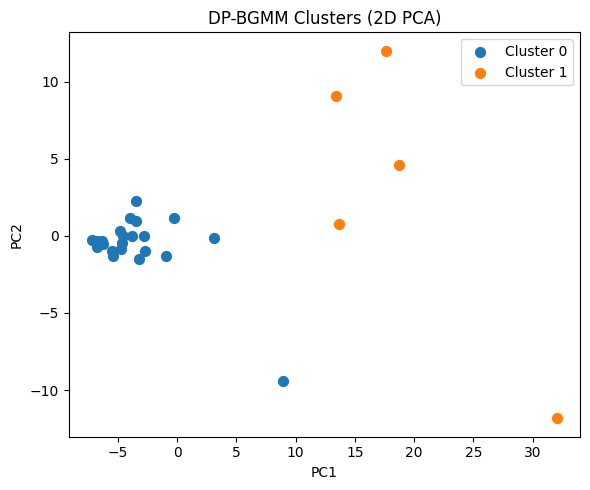

DP-BGMM K=2 Cluster Assignments & Posterior 
             Country  Cluster  Max Posterior Prob
0          Austria        0                 1.0
1          Belgium        0                 1.0
2         Bulgaria        0                 1.0
3          Croatia        0                 1.0
4           Cyprus        0                 1.0
5   Czech Republic        0                 1.0
6          Denmark        0                 1.0
7          Estonia        0                 1.0
8          Finland        0                 1.0
9           France        1                 1.0
10         Germany        1                 1.0
11          Greece        0                 1.0
12         Hungary        0                 1.0
13         Ireland        0                 1.0
14           Italy        1                 1.0
15          Latvia        0                 1.0
16       Lithuania        0                 1.0
17      Luxembourg        0                 1.0
18           Malta        0              

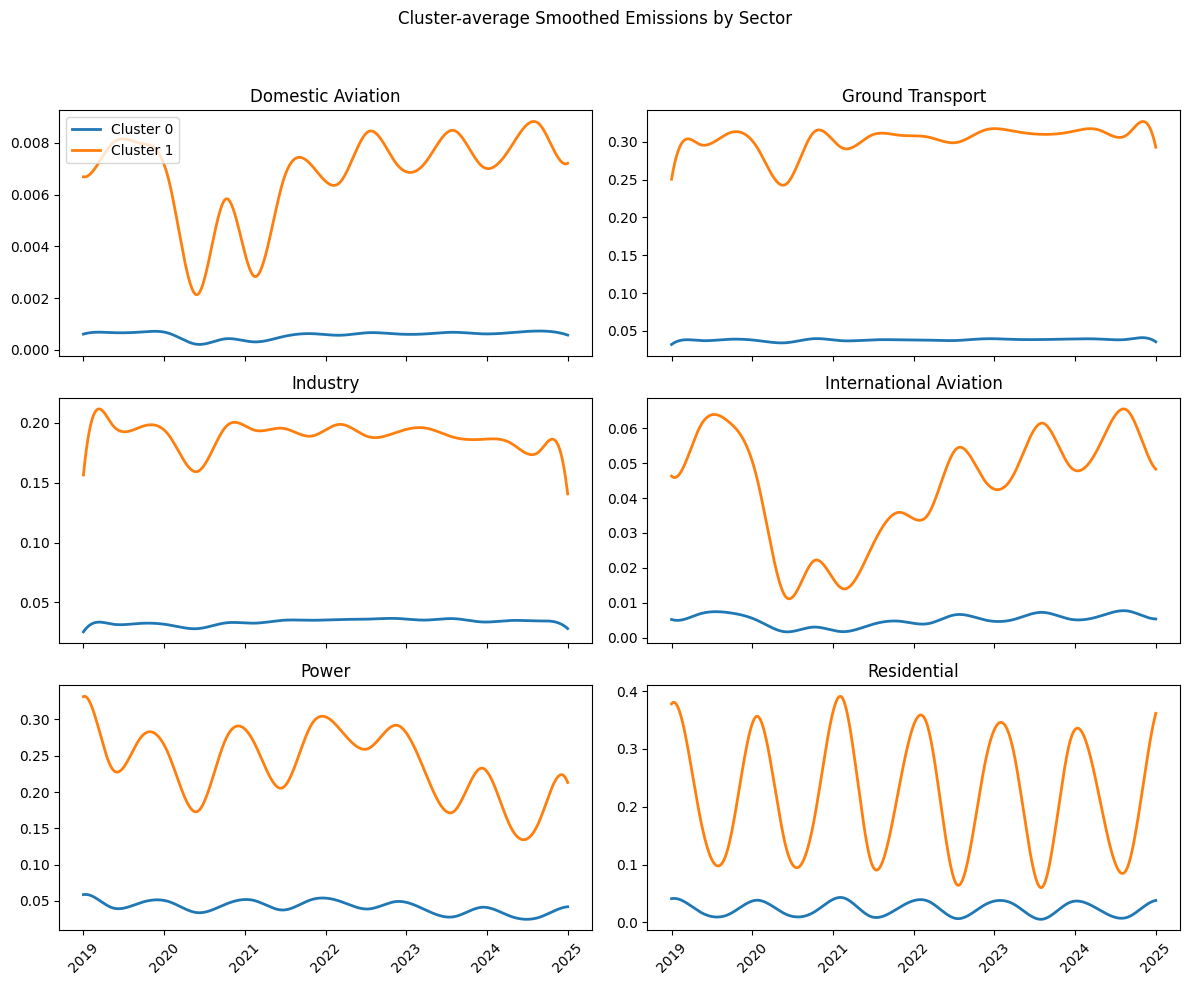

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px

# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
dp_components = 2      # DP-BGMM set to 2 components for K=2
dp_alpha = 0.5         # concentration prior
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

# --- Load & preprocess EU data ---
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()

# --- 1) Extract spline coefficients & smoothed series ---
features = []
smoothed = {c: {} for c in countries}
for country in countries:
    df_ct = EU_data[EU_data['country']==country].sort_values('date').reset_index(drop=True)
    df_ct['t'] = np.arange(len(df_ct))
    # prepare basis once per country
    basis = dmatrix(f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
                    {"t": df_ct['t']}, return_type='dataframe')
    coefs = []
    for sector in sectors:
        y = df_ct[sector].values
        model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
        coefs.extend(model.coef_)
        smoothed[country][sector] = model.predict(basis)
    features.append(coefs)

X = np.array(features)

# --- 2) Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3) Fit DP-BGMM (K=2) ---
dpbgmm = BayesianGaussianMixture(
    n_components=dp_components,
    weight_concentration_prior=dp_alpha,
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    max_iter=1000,
    random_state=42
).fit(X_scaled)
labels = dpbgmm.predict(X_scaled)
probs = dpbgmm.predict_proba(X_scaled)

# --- 4) PCA (3 components) ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# --- 5) 2D PCA Plot ---
plt.figure(figsize=(6,5))
for cl in np.unique(labels):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {cl}', s=50)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('DP-BGMM Clusters (2D PCA)')
plt.legend(); plt.tight_layout()
plt.show()

# --- 6) Trellis via Plotly scatter_matrix ---
pca_df = pd.DataFrame({
    'PCA1': X_pca[:,0], 'PCA2': X_pca[:,1], 'PCA3': X_pca[:,2],
    'Country': countries, 'Cluster': labels.astype(str)
})
fig_matrix = px.scatter_matrix(
    pca_df, dimensions=['PCA1','PCA2','PCA3'], color='Cluster',
    title='Trellis View of DP-BGMM Clusters (PCA)'
)
fig_matrix.update_layout(width=700, height=700)
fig_matrix.show()

# --- 7) 3D PCA Interactive ---
fig_3d = px.scatter_3d(
    pca_df, x='PCA1', y='PCA2', z='PCA3',
    color='Cluster', hover_name='Country',
    title='3D PCA Projection with DP-BGMM (K=2)'
)
fig_3d.show()

# --- 8) Cluster assignment table ---
assign_df = pd.DataFrame({
    'Country': countries,
    'Cluster': labels,
    'Max Posterior Prob': np.max(probs, axis=1)
})
print("DP-BGMM K=2 Cluster Assignments & Posterior \n ", assign_df)

# --- 9) Choropleth map ---
map_df = assign_df.copy()
fig_map = px.choropleth(
    map_df, locations='Country', locationmode='country names',
    color='Cluster', hover_name='Country',
    hover_data={'Max Posterior Prob': ':.4f'},
    title='DP-BGMM K=2 Clusters Across Europe'
)
fig_map.update_layout(geo=dict(scope='europe', showframe=False, showcoastlines=True),
                      margin=dict(r=0,t=50,l=0,b=0))
fig_map.show()

# --- 10) Cluster-average smoothed emissions by sector ---
dates = EU_data[EU_data['country']==countries[0]]['date']
fig, axes = plt.subplots(3,2,figsize=(12,10), sharex=True)
axes = axes.flatten()
for i, sector in enumerate(sectors):
    ax = axes[i]
    for cl in np.unique(labels):
        # collect smoothed series for cluster
        arrs = [smoothed[c][sector] for c, lab in zip(countries, labels) if lab==cl]
        mean_series = np.mean(arrs, axis=0)
        ax.plot(dates, mean_series, label=f'Cluster {cl}', linewidth=2)
    ax.set_title(sector)
    ax.tick_params(axis='x', rotation=45)
axes[0].legend(loc='upper left')
plt.suptitle('Cluster-average Smoothed Emissions by Sector')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


# Jaccard Index for Cluster transitions

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import jaccard_score

# --- Parameters ---
df_spline = 20
degree = 3
alpha = 1.0
dp_components = 2
dp_alpha = 0.5
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']

# --- Load & preprocess ---
EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK'].dropna()
countries = EU_data['country'].unique()

def get_labels_for_period(start, end):
    # Filter data to period
    data = EU_data[(EU_data['date'] >= start) & (EU_data['date'] < end)]
    features = []
    # Extract spline coefficients
    for country in countries:
        df_ct = data[data['country'] == country].sort_values('date').reset_index(drop=True)
        df_ct['t'] = np.arange(len(df_ct))
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True)-1",
            {"t": df_ct['t']}, return_type='dataframe'
        )
        coefs = []
        for sector in sectors:
            y = df_ct[sector].values
            model = Ridge(alpha=alpha, fit_intercept=False).fit(basis, y)
            coefs.extend(model.coef_)
        features.append(coefs)
    X = np.array(features)
    # Standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    # Fit DP-BGMM
    dpbgmm = BayesianGaussianMixture(
        n_components=dp_components,
        weight_concentration_prior=dp_alpha,
        weight_concentration_prior_type='dirichlet_process',
        covariance_type='full',
        max_iter=1000,
        random_state=42
    )
    labels = dpbgmm.fit_predict(Xs)
    return labels

# Get labels for the two windows
labels1 = get_labels_for_period('2019-01-01', '2023-01-01')
labels2 = get_labels_for_period('2020-01-01', '2024-01-01')

# Compute cluster membership sets
sets1 = {c: set(np.array(countries)[labels1 == c]) for c in [0,1]}
sets2 = {c: set(np.array(countries)[labels2 == c]) for c in [0,1]}

# Compute Jaccard indices for cluster mapping
jaccard = {}
for c in [0,1]:
    # Compute J for same label
    jaccard[c] = len(sets1[c] & sets2[c]) / len(sets1[c] | sets2[c])

# Overall stability: fraction of countries with same label
stable = np.sum(labels1 == labels2)
overall_jaccard = stable / len(countries)

# Countries that changed cluster
changed = list(np.array(countries)[labels1 != labels2])

# Prepare summary DataFrame
summary_df = pd.DataFrame({
    'cluster': [0, 1, 'overall'],
    'jaccard_index': [jaccard[0], jaccard[1], overall_jaccard]
})

# Display
print("Cluster membership period1 (2019–2023):", sets1)
print("Cluster membership period2 (2020–2024):", sets2)
print("\nJaccard indices per cluster and overall stability:")
print(summary_df)
print("\nCountries that changed cluster:", changed)


Cluster membership period1 (2019–2023): {0: {'Slovenia', 'Finland', 'Lithuania', 'Estonia', 'Belgium', 'Czech Republic', 'Malta', 'Netherlands', 'Austria', 'Norway', 'Luxembourg', 'Switzerland', 'Denmark', 'Portugal', 'Ireland', 'Poland', 'Cyprus', 'Latvia', 'Slovakia', 'Greece', 'Croatia', 'Sweden', 'Bulgaria', 'Hungary', 'Romania'}, 1: {'Germany', 'France', 'Spain', 'United Kingdom', 'Italy'}}
Cluster membership period2 (2020–2024): {0: {'Slovenia', 'Finland', 'Lithuania', 'Estonia', 'Belgium', 'Czech Republic', 'Malta', 'Netherlands', 'Austria', 'Norway', 'Luxembourg', 'Switzerland', 'Denmark', 'Portugal', 'Ireland', 'Poland', 'Cyprus', 'Latvia', 'Slovakia', 'Greece', 'Croatia', 'Sweden', 'Bulgaria', 'Hungary', 'Romania'}, 1: {'Germany', 'France', 'Spain', 'United Kingdom', 'Italy'}}

Jaccard indices per cluster and overall stability:
   cluster  jaccard_index
0        0            1.0
1        1            1.0
2  overall            1.0

Countries that changed cluster: []


All indices of 1.0 indicate perfect consistency—no country switched clusters between the two periods, confirming that the DP-BGMM K=2 grouping is temporally stable even when the window shifts.

In [ ]:
# --- Build transition counts ---
ct = pd.crosstab(labels1, labels2)

# Sankey diagram setup
node_labels = ['2019–23 C0','2019–23 C1','2020–24 C0','2020–24 C1']
sources, targets, values = [], [], []
for i in ct.index:
    for j in ct.columns:
        sources.append(i)
        targets.append(j + len(ct.index))
        values.append(ct.loc[i, j])

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(label=node_labels, pad=15, thickness=20),
    link=dict(source=sources, target=targets, value=values)
)])
fig.update_layout(
    title="Cluster Transitions: 2019–2023 ➔ 2020–2024",
    font_size=10
)
fig.show()

created a Sankey diagram showing the flow of countries between clusters in the two periods:

Left nodes (2019–23 clusters)

Right nodes (2020–24 clusters)

Link widths represent how many countries transitioned between each cluster pairing.

In our case, all flows remain on the diagonal (Cluster 0→0 and 1→1), visualizing the perfect stability (Jaccard=1.0).

This effectively communicates cluster stability over time.

# Key observations

* What we’re observing is a combination of two facts:

Variational “DP-BGMM” in scikit-learn is a point-estimate algorithm

It uses a variational EM to fit a truncated Dirichlet-process mixture, but at the end we still get a single set of learned component weights and parameters—not a full posterior distribution over them.

When we call .predict_proba(X), we’re computing the posterior probability of each data point belonging to each component, given those fixed parameters.

If our two clusters (or any cluster and its nearest neighbor) are well separated in feature space, those posterior probabilities collapse to 1 for the “closest” component and 0 for the others. That’s exactly what we saw: crisp assignments, no ambiguity.

* Our data truly splits into two “clean” groups by scale

As we saw, the first principal component of our spline coefficients largely captures overall emission level. Whether we give the model n_components=2, or let it truncate at 10 and then collapse to 2 meaningful clusters, it ends up with two very distinct groups, and no country sits on the fence.

If we force higher truncation (say 10), the DP prior will carve off “singleton” clusters with tiny weights—but any country that does end up in one of those singleton clusters is also assigned with probability ≈1.



In summary
What’s happening is exactly what the algorithm is designed to do: give us one “best” clustering, with hard/soft assignments collapsed because our data cleanly supports two groups.

**We’re not seeing full Bayesian uncertainty because scikit-learn’s DP-BGMM is a point-estimate variational method.**

# Cluster Prototype

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from patsy import dmatrix
import plotly.graph_objects as go

In [3]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

EU_data = pd.read_csv("/content/drive/MyDrive/Dataset/Europe_Carbon_Monitor_Final.csv")
EU_data['date'] = pd.to_datetime(EU_data['date'])
EU_data = EU_data[EU_data['country'] != 'EU27 & UK']
EU_data.dropna(inplace=True)

In [4]:
sectors = ['Domestic Aviation', 'Ground Transport', 'Industry',
           'International Aviation', 'Power', 'Residential']
countries = EU_data['country'].unique()

In [7]:
df_spline = 20
degree = 3
alpha = 1.0

# --- Feature Extraction: spline coefficients ---
features = []
for country in countries:
    df_country = EU_data[EU_data["country"] == country].sort_values("date").reset_index(drop=True)
    df_country['t'] = np.arange(len(df_country))
    coefs = []
    for sector in sectors:
        basis = dmatrix(
            f"bs(t, df={df_spline}, degree={degree}, include_intercept=True) - 1",
            {"t": df_country['t']},
            return_type='dataframe'
        )
        ridge = Ridge(alpha=alpha, fit_intercept=False).fit(basis, df_country[sector])
        coefs.extend(ridge.coef_)
    features.append(coefs)

X = np.array(features)
X_scaled = StandardScaler().fit_transform(X)

In [8]:
print(X) #120 spline features

[[ 8.45847728e-05  1.31162053e-04  1.26774353e-04 ... -8.83260229e-03
   3.86691030e-02  4.36988109e-02]
 [ 1.09350600e-05  2.30597378e-05  1.46937494e-05 ... -1.09069530e-03
   8.90651916e-02  9.79171129e-02]
 [ 3.96305624e-05  1.57741584e-05  6.60645214e-05 ...  3.39113585e-04
   6.20632705e-03  6.68759567e-03]
 ...
 [ 1.44950573e-03  2.91914780e-03  1.73987459e-03 ... -1.41270966e-03
   6.57826956e-03  5.74741768e-03]
 [ 1.35939781e-04  2.07428967e-04  2.75746267e-04 ... -9.95309041e-03
   5.38066320e-02  6.76241623e-02]
 [ 3.49737491e-03  3.94946657e-03  5.12663375e-03 ...  3.53563561e-02
   3.04178621e-01  2.81211608e-01]]


In [12]:
# Re-run all necessary code since the state has been reset

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Simulate loading the spline feature matrix (X) and country labels
# Replace X and country_labels with your actual spline features and names
country_labels = countries

# 1. Compute distance matrix
dist_matrix = pdist(X, metric='euclidean')
square_dists = squareform(dist_matrix)

# 2. Perform hierarchical clustering using complete linkage (minimax proxy)
Z = linkage(dist_matrix, method='complete')

# 3. Choose number of clusters (e.g., 3) or height (can be tuned)
n_clusters = 3
cluster_assignments = fcluster(Z, n_clusters, criterion='maxclust')

# 4. Find prototype: the country in each cluster with minimum max distance to others
prototypes = {}
for cluster_id in np.unique(cluster_assignments):
    cluster_indices = np.where(cluster_assignments == cluster_id)[0]
    cluster_points = X[cluster_indices]
    max_dists = []
    for i, point in enumerate(cluster_points):
        d = np.max(np.linalg.norm(point - cluster_points, axis=1))
        max_dists.append((d, cluster_indices[i]))
    _, prototype_index = min(max_dists)
    prototypes[cluster_id] = prototype_index

# 5. Create result DataFrame
cluster_info = []
for cid, p_index in prototypes.items():
    prototype_country = country_labels[p_index]
    members = [country_labels[i] for i in np.where(cluster_assignments == cid)[0]]
    cluster_info.append({
        'Cluster': cid,
        'Prototype': prototype_country,
        'Members': members
    })

prototypes_df = pd.DataFrame(cluster_info)

print("Minimax Prototype Clusters\n",prototypes_df)


Minimax Prototype Clusters
    Cluster Prototype                                            Members
0        1   Romania  [Austria, Belgium, Bulgaria, Croatia, Cyprus, ...
1        2     Italy     [France, Italy, Poland, Spain, United Kingdom]
2        3   Germany                                          [Germany]


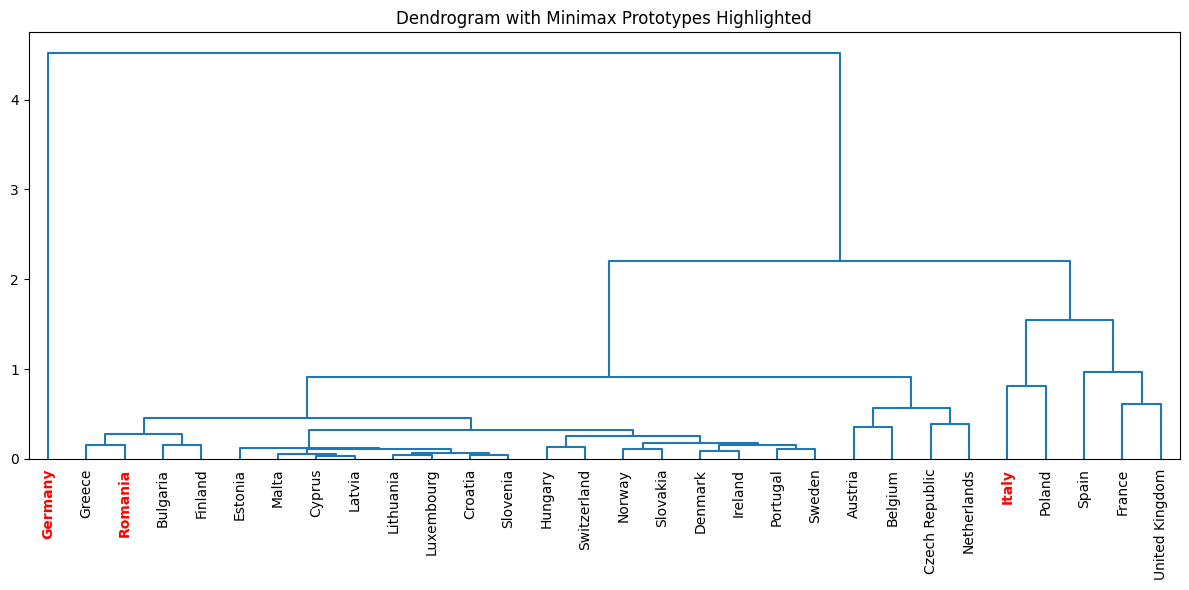

In [10]:
# Plot dendrogram with prototype labels highlighted

plt.figure(figsize=(12, 6))
dendro = dendrogram(Z, labels=country_labels, leaf_rotation=90, leaf_font_size=10, color_threshold=0)

# Overlay prototype labels on the dendrogram
prototype_indices = list(prototypes.values())
prototype_labels = [country_labels[i] for i in prototype_indices]

# Find the x-tick locations and annotate prototypes
ax = plt.gca()
xticks = ax.get_xticklabels()
for tick in xticks:
    if tick.get_text() in prototype_labels:
        tick.set_color('red')
        tick.set_fontweight('bold')

plt.title("Dendrogram with Minimax Prototypes Highlighted")
plt.tight_layout()
plt.show()
